In [69]:

import sys
sys.path.append('../codes')
import torch
from torch import nn
import numpy as np
import pandas as pd
import networks
import utils
import config
import loss
import trainer
import evaluator
import plots
from scipy.stats import spearmanr
from captum.attr import DeepLift
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
color_pallete = tuple(sns.color_palette("husl", 9))
colors = []
for color in color_pallete:
    color = [color,] * 9
    colors += color

In [71]:
class fc_avg_net_over_geno(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(fc_avg_net_over_geno, self).__init__()
        
        self.representation = None
        
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.25)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.25)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.25)
        
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(p=0.25)
        
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.relu5 = nn.ReLU()
        self.drop5 = nn.Dropout(p=0.25)
        
        self.fc5 = nn.Linear(hidden_dim, 1)
        
        
        
    def forward(self, x):
        
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.drop1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.drop3(out)
        
        out = self.fc4(out)
        
        out = self.relu4(out)
        representation = out
        out = self.drop4(out)
        
        
        
        
        out = self.fc5(out)

        
        
        
        return out
        

In [72]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


## Unique Line

In [73]:
versions = ['v1', 'v2', 'v3', 'v4', 'v5']

avg_attributions = np.zeros((81,))
for version in versions:
    test_file = '../processed_data/test_geno_with_8_m_avg_all_data_{}.pkl'.format(version)
    model_avg_by_env_path = '../outputs/fc_model_avg_by_env_version_{}.pt'.format(version)
    test_loader = utils.create_dataloader_by_env_avg(test_file, is_training=False)
    mdl_avg_over_geno = fc_avg_net_over_geno(num_features = test_loader.dataset.data.shape[1], hidden_dim=54)
    mdl_avg_over_geno.load_state_dict(torch.load(model_avg_by_env_path))
    mdl_avg_over_geno.to(device=device)                                                    
    
    data = test_loader.dataset.data
    data = torch.from_numpy(data)
    data = data.float()
    data = data.to(device=device)

    
    baseline = torch.zeros(data.shape)
    baseline = baseline.to(device=device)
    
    target = torch.from_numpy(test_loader.dataset.target)
    target = target.to(device)
    
    
    dl = DeepLift(mdl_avg_over_geno)
    
    attributions, delta = dl.attribute(data, baseline, target=0, return_convergence_delta=True)
    attributions_sum = attributions.cpu().detach().numpy().sum(0)
    attributions_norm_sum = attributions_sum / np.linalg.norm(attributions_sum, ord=1)
    
    avg_attributions += attributions_norm_sum
    
    
    

/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attr

In [74]:
avg_attributions = avg_attributions/len(versions)
# avg_attributions = avg_attributions.reshape(9, -1)

In [75]:
# avg_attributions = avg_attributions.sum(0)
ticks = ['Precipitation', 'Humidity max', 'Humidity min', 'Radiation', 'Temp max', 'Temp min', 'Vap. pressure', 'Wind 2m', 'Wind 5m']

In [76]:
# for i in range(avg_attributions.shape[0]):
    
#     plt.figure(figsize=(12,8))
#     ax=sns.barplot(x=np.arange(1, 10), y=avg_attributions[i, :])
#     ax.set_ylabel('Attribution', fontsize=14)
#     ax.set_xlabel('Features', fontsize=14)
#     ax.set_ylim((-0.07,0.07))
#     ax.set_xticklabels(ticks)
#     fig = ax.get_figure()
#     fig.savefig('../figures/feature_importance_env_over_geno_unique_line_month_{}.jpeg'.format(i), dpi=600)

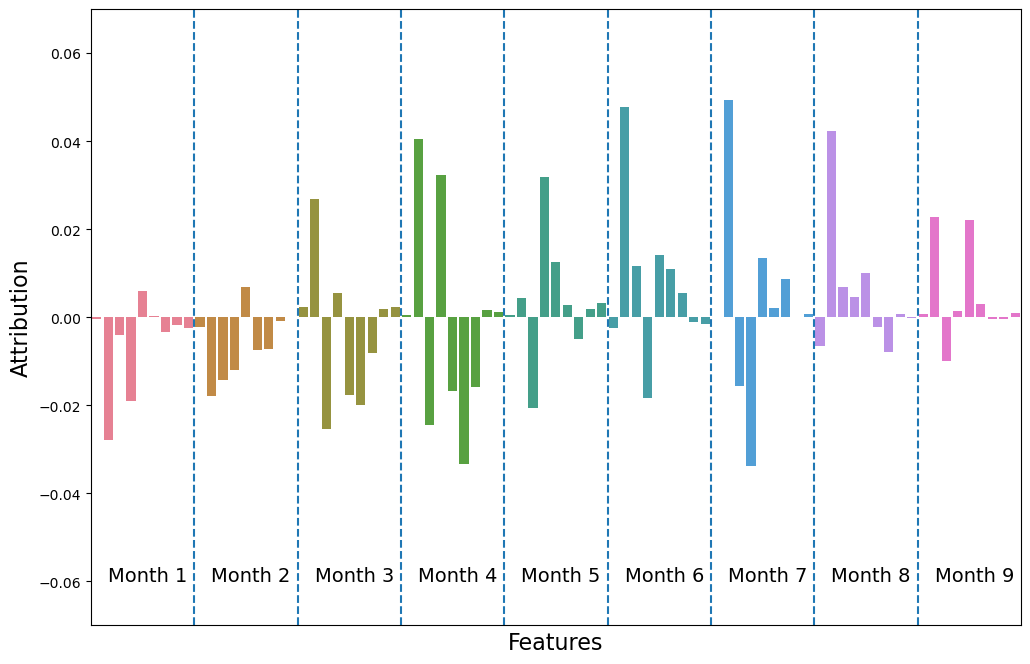

In [77]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x=np.arange(1, 82), y=avg_attributions, palette=colors)
ax.set_ylabel('Attribution', fontsize=16)
ax.set_xlabel('Features', fontsize=16)
ax.set_ylim((-0.07,0.07))
ax.set_xticks([])
plt.axvline(x=9-0.5, linestyle='--')
plt.axvline(x=18-0.50, linestyle='--')
plt.axvline(x=27-0.50, linestyle='--')
plt.axvline(x=36-0.50, linestyle='--')
plt.axvline(x=45-0.50, linestyle='--')
plt.axvline(x=54-0.50, linestyle='--')
plt.axvline(x=63-0.50, linestyle='--')
plt.axvline(x=72-0.50, linestyle='--')
plt.text(1, -0.060, 'Month 1', fontsize=14)
plt.text(10, -0.060, 'Month 2', fontsize=14)
plt.text(19, -0.060, 'Month 3', fontsize=14)
plt.text(28, -0.060, 'Month 4', fontsize=14)
plt.text(37, -0.060, 'Month 5', fontsize=14)
plt.text(46, -0.060, 'Month 6', fontsize=14)
plt.text(55, -0.060, 'Month 7', fontsize=14)
plt.text(64, -0.060, 'Month 8', fontsize=14)
plt.text(73, -0.060, 'Month 9', fontsize=14)
# plt.text(120, -0.010, 'Marker representation')
fig = ax.get_figure()
fig.savefig('../figures/feature_importance_env_over_geno_unique_line.jpeg', dpi=600, bbox_inches='tight')

## Unique Env

In [78]:
versions = ['v1', 'v2', 'v3', 'v4', 'v5']

avg_attributions = np.zeros((81,))
for version in versions:
    test_file = '../processed_data/test_geno_unique_env_with_8_m_avg_all_data_{}.pkl'.format(version)
    model_avg_by_env_path = '../outputs/fc_model_avg_by_env_version_{}.pt'.format(version)
    test_loader = utils.create_dataloader_by_env_avg(test_file, is_training=False)
    mdl_avg_over_geno = fc_avg_net_over_geno(num_features = test_loader.dataset.data.shape[1], hidden_dim=54)
    mdl_avg_over_geno.load_state_dict(torch.load(model_avg_by_env_path))
    mdl_avg_over_geno.to(device=device)                                                    
    
    data = test_loader.dataset.data
    data = torch.from_numpy(data)
    data = data.float()
    data = data.to(device=device)
    
    baseline = torch.zeros(data.shape)
    baseline = baseline.to(device=device)
    
    dl = DeepLift(mdl_avg_over_geno)
    
    attributions, delta = dl.attribute(data, baseline, target=0, return_convergence_delta=True)
    attributions_sum = attributions.cpu().detach().numpy().sum(0)
    attributions_norm_sum = attributions_sum / np.linalg.norm(attributions_sum, ord=1)
    
    avg_attributions += attributions_norm_sum
    
    
    

/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attr

In [79]:
avg_attributions = avg_attributions/len(versions)
# avg_attributions = avg_attributions.reshape(9, -1)

In [80]:
# for i in range(avg_attributions.shape[0]):
    
#     plt.figure(figsize=(12,8))
#     ax=sns.barplot(x=np.arange(1, 10), y=avg_attributions[i, :])
#     ax.set_ylabel('Attribution', fontsize=14)
#     ax.set_xlabel('Features', fontsize=14)
#     ax.set_ylim((-0.07,0.07))
#     ax.set_xticklabels(ticks)
#     fig = ax.get_figure()
#     fig.savefig('../figures/feature_importance_env_over_geno_unique_env_month_{}.jpeg'.format(i), dpi=600)

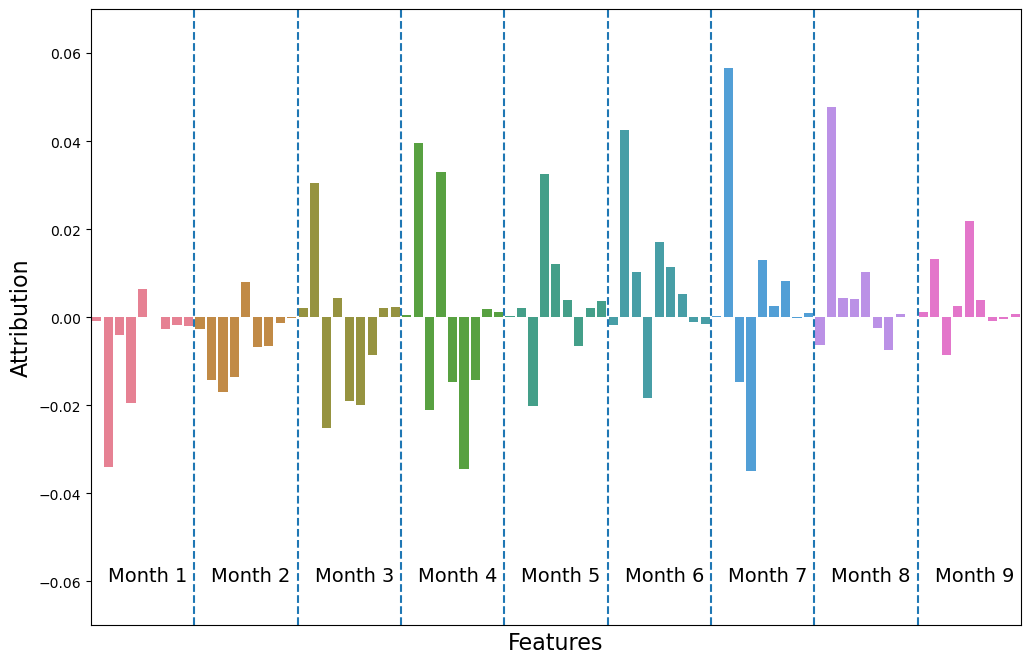

In [81]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x=np.arange(1, 82), y=avg_attributions, palette=colors)
ax.set_ylabel('Attribution', fontsize=16)
ax.set_xlabel('Features', fontsize=16)
ax.set_ylim((-0.07,0.07))
ax.set_xticks([])
plt.axvline(x=9-0.5, linestyle='--')
plt.axvline(x=18-0.50, linestyle='--')
plt.axvline(x=27-0.50, linestyle='--')
plt.axvline(x=36-0.50, linestyle='--')
plt.axvline(x=45-0.50, linestyle='--')
plt.axvline(x=54-0.50, linestyle='--')
plt.axvline(x=63-0.50, linestyle='--')
plt.axvline(x=72-0.50, linestyle='--')
plt.text(1, -0.060, 'Month 1', fontsize=14)
plt.text(10, -0.060, 'Month 2', fontsize=14)
plt.text(19, -0.060, 'Month 3', fontsize=14)
plt.text(28, -0.060, 'Month 4', fontsize=14)
plt.text(37, -0.060, 'Month 5', fontsize=14)
plt.text(46, -0.060, 'Month 6', fontsize=14)
plt.text(55, -0.060, 'Month 7', fontsize=14)
plt.text(64, -0.060, 'Month 8', fontsize=14)
plt.text(73, -0.060, 'Month 9', fontsize=14)
# plt.text(120, -0.010, 'Marker representation')
fig = ax.get_figure()
fig.savefig('../figures/feature_importance_env_over_geno_unique_env.jpeg', dpi=600, bbox_inches='tight')

### By trial

In [39]:
versions = ['v1', 'v2', 'v3', 'v4', 'v5']

avg_attributions = np.zeros((81,))

target_trial = 'WYCYT'
ind = []
for version in versions:
    ind = []
    test_file = '../processed_data/test_geno_with_8_m_avg_all_data_{}.pkl'.format(version)
    model_avg_by_env_path = '../outputs/fc_model_avg_by_env_version_{}.pt'.format(version)
    test_loader = utils.create_dataloader_by_env_avg(test_file, is_training=False)
    mdl_avg_over_geno = fc_avg_net_over_geno(num_features = test_loader.dataset.data.shape[1], hidden_dim=54)
    mdl_avg_over_geno.load_state_dict(torch.load(model_avg_by_env_path))
    mdl_avg_over_geno.to(device=device)                                                    
    
    data = test_loader.dataset.data
    trials = test_loader.dataset.trial
    
    for x in trials:
        if target_trial in x:
            ind.append(True)
        else:
            ind.append(False)
    
    
    ind = np.array(ind)
    data = data[ind]
    
    
    data = torch.from_numpy(data)
    data = data.float()
    data = data.to(device=device)
    
    baseline = torch.zeros(data.shape)
    baseline = baseline.to(device=device)
    
    dl = DeepLift(mdl_avg_over_geno)
    
    attributions, delta = dl.attribute(data, baseline, target=0, return_convergence_delta=True)
    attributions_sum = attributions.cpu().detach().numpy().sum(0)
    attributions_norm_sum = attributions_sum / np.linalg.norm(attributions_sum, ord=1)
    
    avg_attributions += attributions_norm_sum
    
    
    

/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/amii.ca/jsheikh/anaconda3/envs/blackice/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attr

In [40]:
avg_attributions = avg_attributions/len(versions)

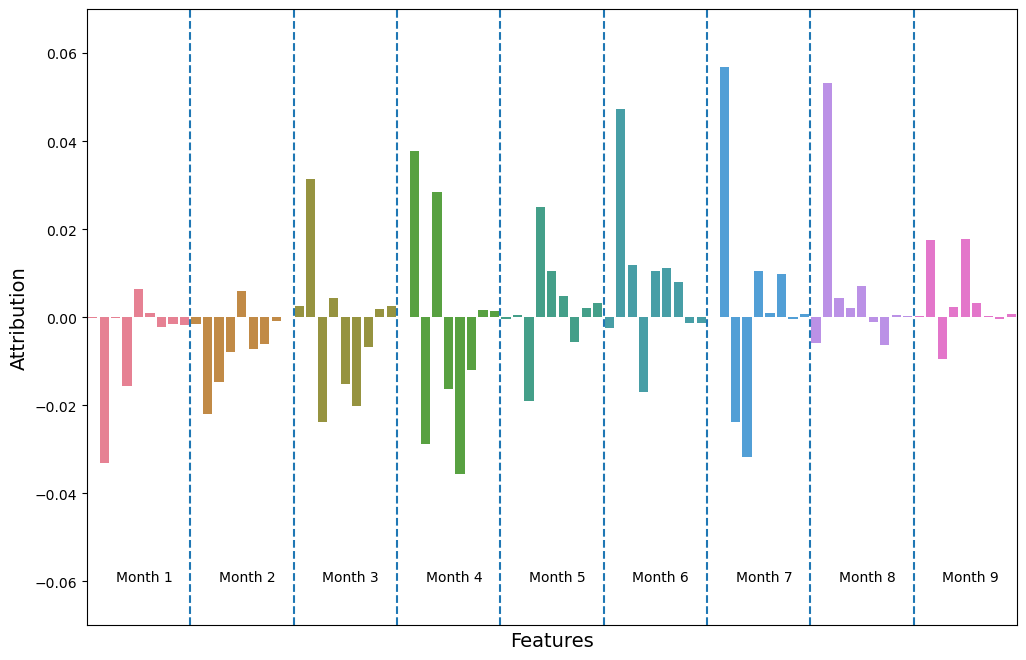

In [41]:

plt.figure(figsize=(12,8))
ax=sns.barplot(x=np.arange(1, 82), y=avg_attributions, palette=colors)
ax.set_ylabel('Attribution', fontsize=14)
ax.set_xlabel('Features', fontsize=14)
ax.set_ylim((-0.07,0.07))
ax.set_xticks([])
plt.axvline(x=9-0.5, linestyle='--')
plt.axvline(x=18-0.50, linestyle='--')
plt.axvline(x=27-0.50, linestyle='--')
plt.axvline(x=36-0.50, linestyle='--')
plt.axvline(x=45-0.50, linestyle='--')
plt.axvline(x=54-0.50, linestyle='--')
plt.axvline(x=63-0.50, linestyle='--')
plt.axvline(x=72-0.50, linestyle='--')
plt.text(2, -0.060, 'Month 1')
plt.text(11, -0.060, 'Month 2')
plt.text(20, -0.060, 'Month 3')
plt.text(29, -0.060, 'Month 4')
plt.text(38, -0.060, 'Month 5')
plt.text(47, -0.060, 'Month 6')
plt.text(56, -0.060, 'Month 7')
plt.text(65, -0.060, 'Month 8')
plt.text(74, -0.060, 'Month 9')
# plt.text(120, -0.010, 'Marker representation')
fig = ax.get_figure()
fig.savefig('../figures/feature_importance_env_over_geno_unique_line_trial_{}.jpeg'.format(target_trial), dpi=600)
